# Online inference with the Ensemble Kalman filter

In [1]:
import jax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

In [143]:
from jax.flatten_util import ravel_pytree
import flax.linen as nn

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")
palette = sns.color_palette()

## Ensemble KF

In [4]:
key = jax.random.PRNGKey(314)
key_data, key_filter = jax.random.split(key)
key_x, key_y, key_coef, key_samples = jax.random.split(key_data, 4)

In [146]:
m = 1
n_test = 200
n_samples = 500 + n_test

# coefs = jax.random.uniform(key_coef, shape=(m,) ,minval=-3, maxval=3)
coefs = jnp.array([0.1, 0.8, 0.3, -0.1])
xmin, xmax = -4, 4
X = jax.random.uniform(key_x, (n_samples, m)) * (xmax - xmin) + xmin
Phi = jnp.c_[X ** 0, X ** 1, X ** 2, X** 3]

errs = jax.random.normal(key_y, (n_samples,))
y = jnp.einsum("sm,m->s", Phi, coefs) + errs
y = jnp.atleast_2d(y).T

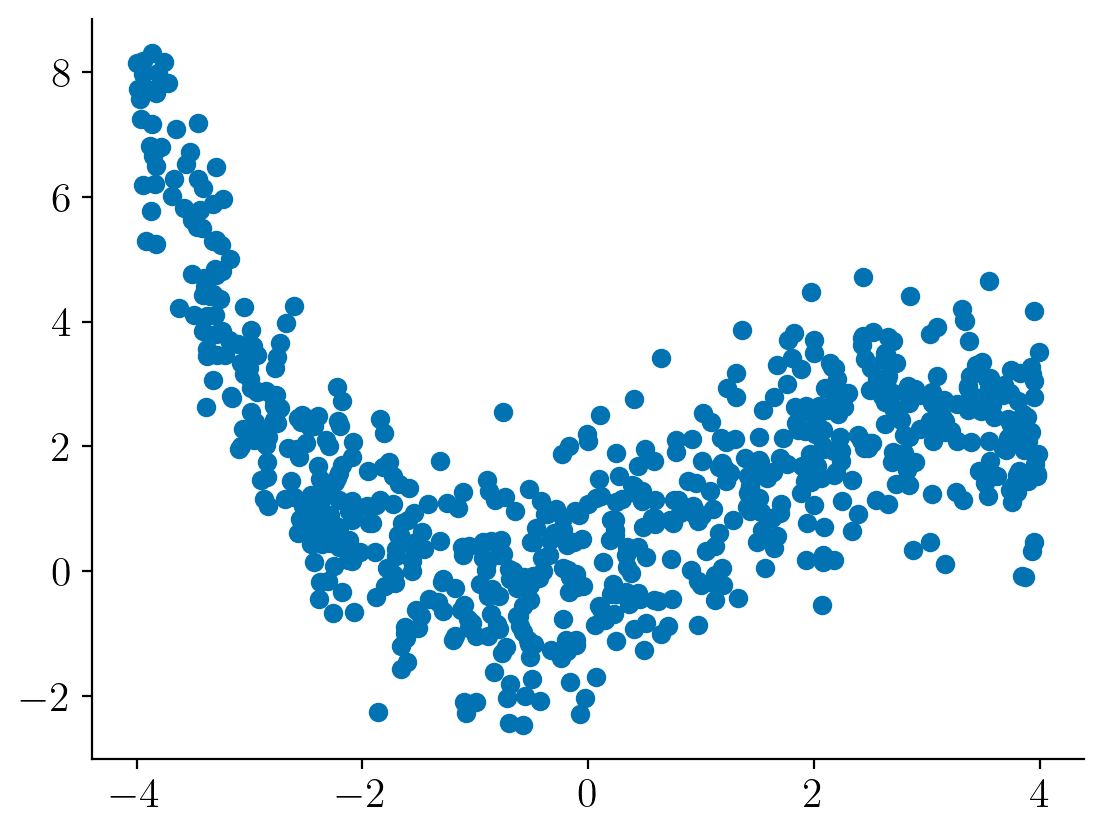

In [147]:
plt.scatter(X, y)

In [148]:
key_init, key_scan = jax.random.split(key_filter, )

In [149]:
model = MLP()

In [154]:
@partial(jax.vmap, in_axes=(0, None))
def h(theta, x):
    return theta @ x

@partial(jax.vmap, in_axes=(None, 0))
@partial(jax.vmap, in_axes=(0, None))
def h_phi(theta, x):
    phi = jnp.array([x ** 0, x ** 1, x ** 2, x ** 3])
    return theta @ phi

In [155]:
n_ensemble = 100
ensemble = jax.random.normal(key_init, (n_ensemble, len(coefs)))

In [156]:
xeval = jnp.linspace(xmin, xmax, 200)

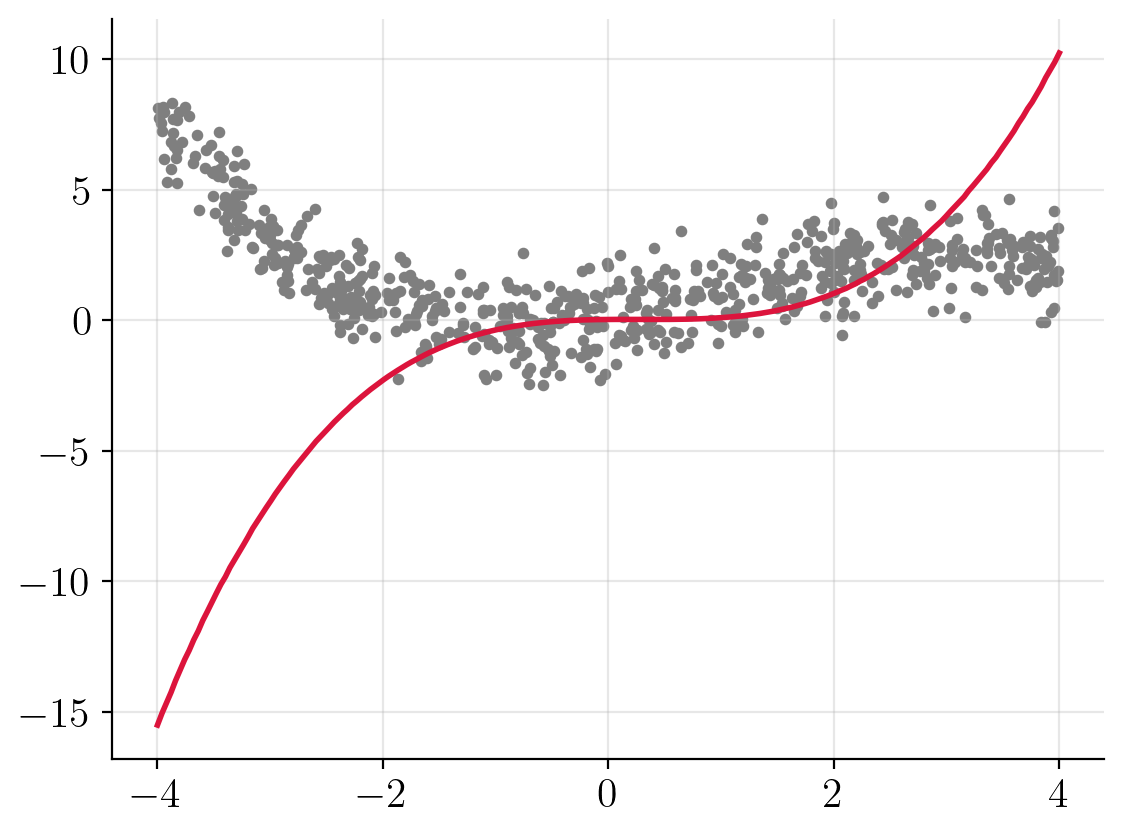

In [158]:
plt.scatter(X, y, c="tab:gray", s=10)
plt.plot(xeval, h_phi(ensemble, xeval).mean(axis=-1), c="crimson")
plt.grid(alpha=0.3)

In [159]:
def enkf_step(ensemble, xs):
    key_step, yt, phit = xs
    
    ensemble_pred = ensemble
    y_pred = h(ensemble, phit)[:, None] + jax.random.normal(key_step, (n_ensemble,1))

    ensemble_mean = ensemble_pred.mean(axis=0, keepdims=True)
    y_mean = y_pred.mean(axis=0, keepdims=True)

    ensemble_err = ensemble_pred - ensemble_mean
    y_err = y_pred - y_mean
    CT = jnp.einsum("si,sj->ji", ensemble_err, y_err) / n_ensemble
    VT = jnp.einsum("si,sj->ji", y_err, y_err) / n_ensemble
    K = jnp.linalg.solve(VT, CT).T

    ensemble = ensemble_pred + jnp.einsum("ij,sj->si", K, yt - y_pred)
    return ensemble, ensemble

In [160]:
keys = jax.random.split(key_scan, n_samples)

In [161]:
xs_hist = (keys, y, Phi)
ensemble_final, ensemble_hist = jax.lax.scan(enkf_step, ensemble, xs_hist)

In [162]:
ensemble_hist.shape

(700, 100, 4)

In [163]:
coefs

Array([ 0.1,  0.8,  0.3, -0.1], dtype=float32)

In [164]:
ensemble_final.mean(axis=0)

Array([ 0.08656066,  0.8396369 ,  0.31419843, -0.09853343], dtype=float32)

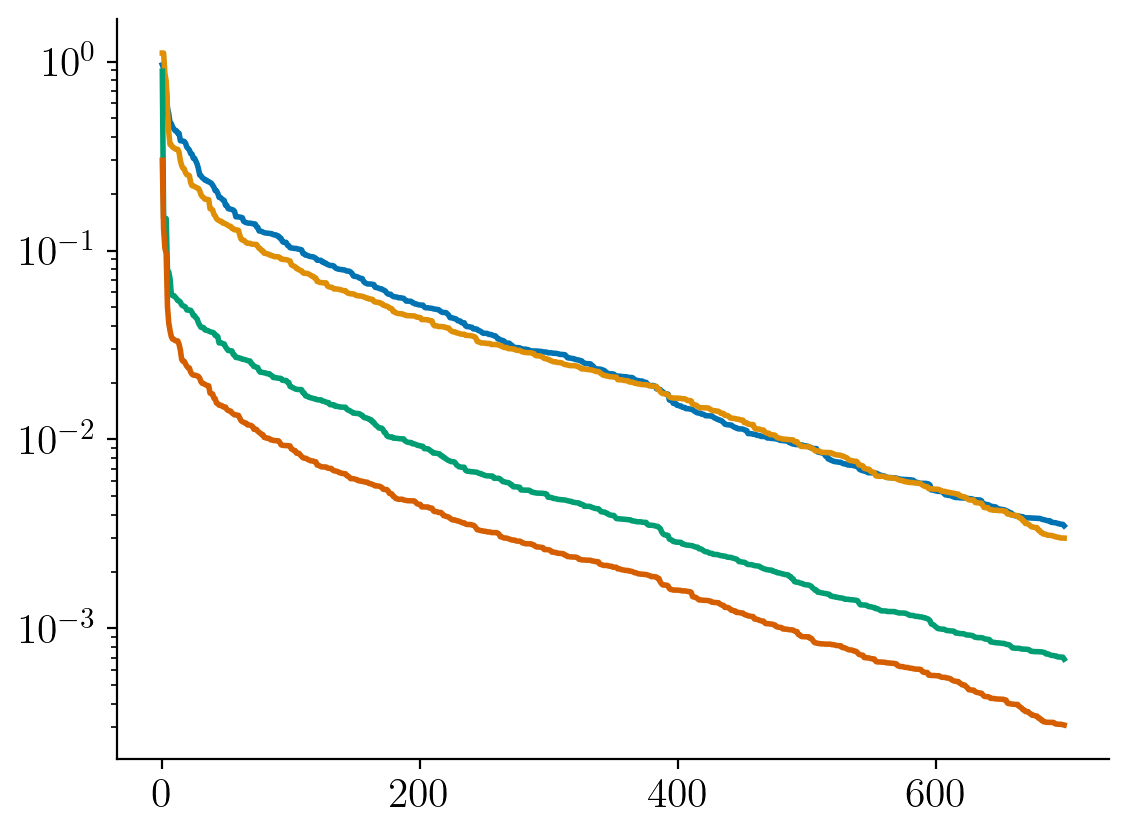

In [165]:
plt.plot(ensemble_hist.std(axis=1))
plt.yscale("log")

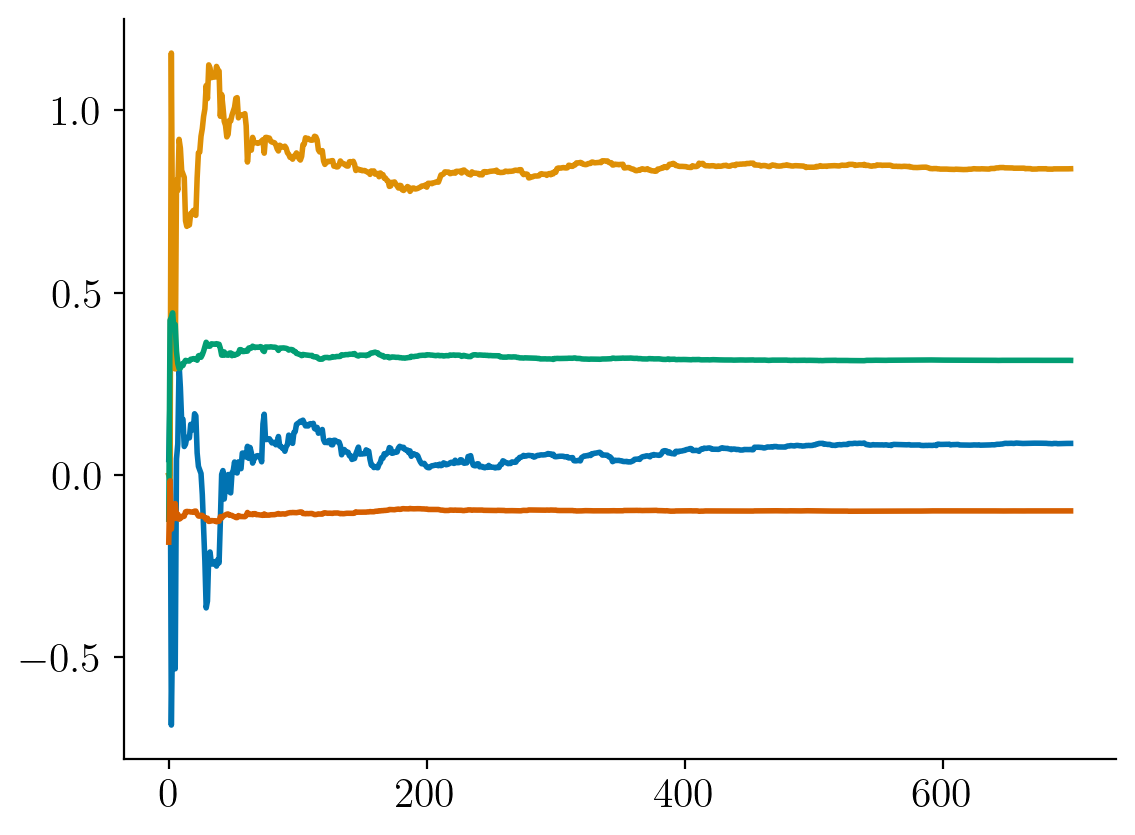

In [166]:
plt.plot(ensemble_hist.mean(axis=1))

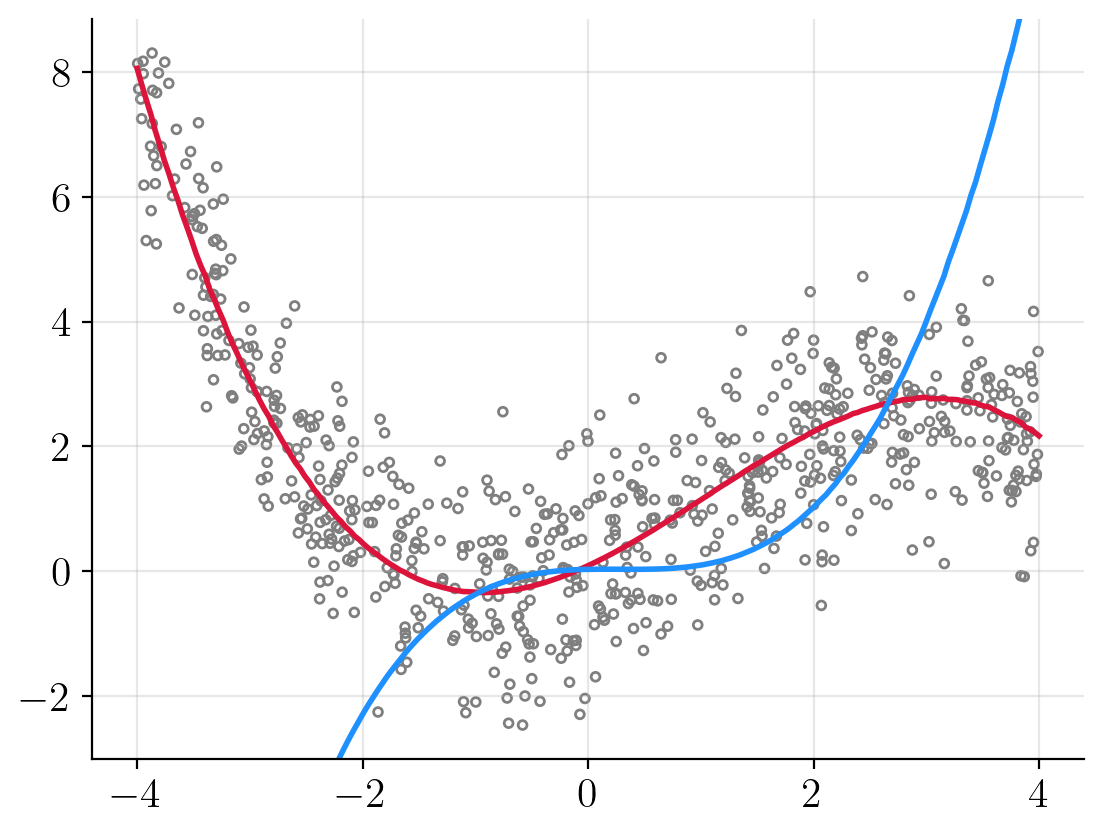

In [167]:
plt.scatter(X, y, c="none", s=10, edgecolor="tab:gray")
plt.plot(xeval, h_phi(ensemble_final, xeval).mean(axis=-1), c="crimson")
ymin, ymax = plt.ylim()
plt.plot(xeval, h_phi(ensemble, xeval).mean(axis=-1), c="dodgerblue")
plt.ylim(ymin, ymax)
plt.grid(alpha=0.3)

## An MLP

In [332]:
class MLP(nn.Module):
    def setup(self):
        self.activation = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = jnp.cos(x)
        x = nn.Dense(5)(x)
        x = self.activation(x)
        x = nn.Dense(5)(x)
        x = self.activation(x)
        x = nn.Dense(1)(x)
        # x = nn.sigmoid(x)
        return x

In [333]:
model = MLP()

In [334]:
ensemble_init = model.init(key_init, X[0])
params, rfn = ravel_pytree(ensemble_init)
ensemble = jax.random.normal(key_init, (n_ensemble, len(params)))

In [335]:
@partial(jax.vmap, in_axes=(0, None))
def h(theta, x):
    theta = rfn(theta)
    return model.apply(theta, x)


@partial(jax.vmap, in_axes=(None, 0))
@partial(jax.vmap, in_axes=(0, None))
def h_vmap(theta, x):
    theta = rfn(theta)
    return model.apply(theta, x)

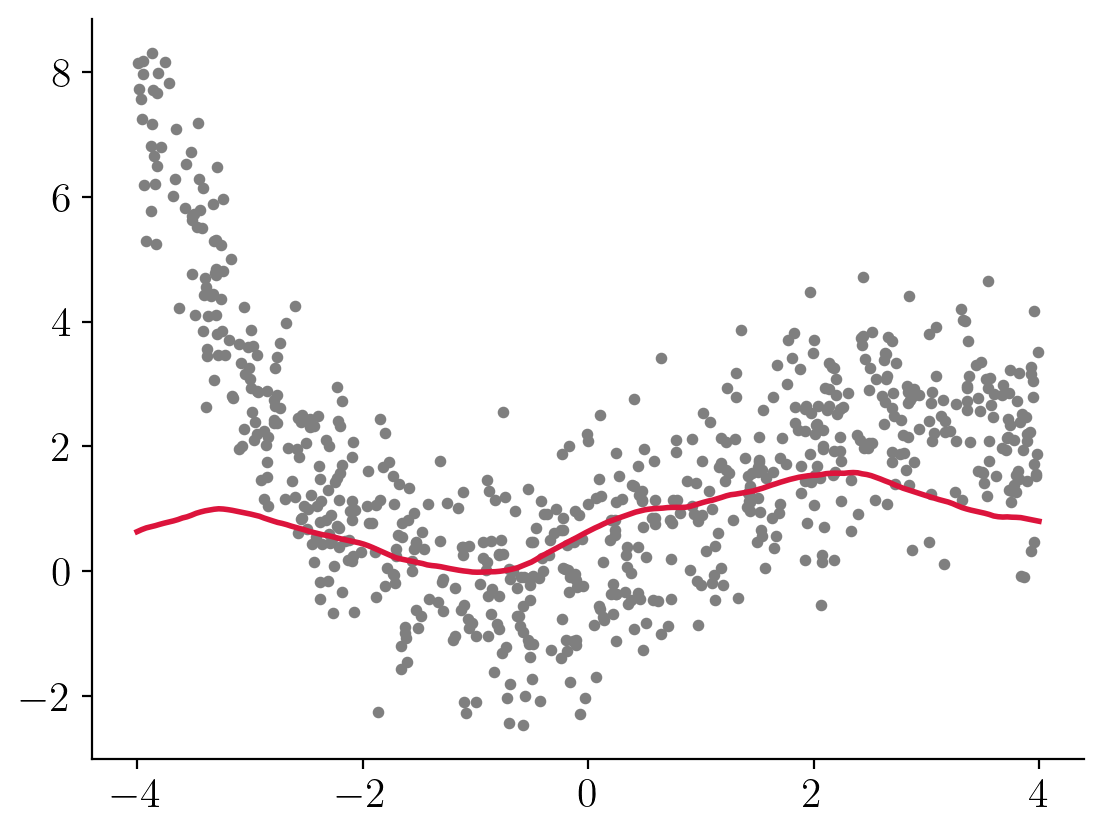

In [336]:
plt.plot(xeval, h_vmap(ensemble, xeval[:, None]).squeeze().mean(axis=-1), c="crimson")
plt.scatter(X, y, c="tab:gray", s=10)

## Inflation factor

In [337]:
def enkf_step(ensemble, xs, c=1.01):
    key_step, yt, xt = xs
    
    ensemble_pred = ensemble
    y_pred = h(ensemble, xt) + jax.random.normal(key_step, (n_ensemble,1))

    ensemble_mean = ensemble_pred.mean(axis=0, keepdims=True)
    y_mean = y_pred.mean(axis=0, keepdims=True)

    ensemble_err = ensemble_pred - ensemble_mean
    y_err = y_pred - y_mean
    CT = jnp.einsum("si,sj->ji", ensemble_err, y_err) / n_ensemble
    VT = jnp.einsum("si,sj->ji", y_err, y_err) / n_ensemble
    K = jnp.linalg.solve(c * VT, CT).T

    ensemble = ensemble_pred + jnp.einsum("ij,sj->si", K, yt - y_pred)
    return ensemble, ensemble

In [338]:
keys = jax.random.split(key_scan, n_samples)

In [339]:
xs_hist = (keys, y, X)
ensemble_final, ensemble_hist = jax.lax.scan(enkf_step, ensemble, xs_hist)

In [340]:
ensemble_hist.shape

(700, 100, 76)

In [341]:
ensemble_final.mean(axis=0)

Array([-1.5926764 ,  0.5240527 ,  2.1163092 ,  0.6253005 ,  0.62007576,
       -0.5496889 ,  0.6552945 , -0.75206435, -0.23638052,  0.3086778 ,
        0.68759286,  0.3964652 , -0.45053828,  1.1097753 ,  0.68350255,
        0.08382876,  0.12714998,  0.7131699 , -2.341708  ,  1.615379  ,
       -1.5108615 ,  0.8134421 ,  1.9707427 ,  0.31570557,  0.11769974,
       -0.35197258,  0.93895924,  0.76249707,  0.8174689 , -0.948696  ,
       -0.25525004,  0.4227365 ,  1.6698914 ,  0.5343077 ,  0.2817786 ,
        1.8767316 , -0.8756665 , -0.24691375, -1.4161783 ,  1.0783849 ,
        0.19475761, -0.9927413 , -0.4875446 , -1.1924272 ,  0.7015318 ,
        1.7401419 , -0.07523847,  0.66677016,  0.40338355,  0.8477496 ,
       -0.34828323,  0.7015032 , -0.9677233 , -1.5061412 , -1.1662093 ,
       -1.3933051 , -1.467908  , -0.00504113,  0.44662893, -0.16731374,
        0.21236743, -0.7331329 , -0.24268174,  0.48460266, -0.29186332,
        0.07205173,  0.08425134,  0.26977405,  0.03482293, -0.61

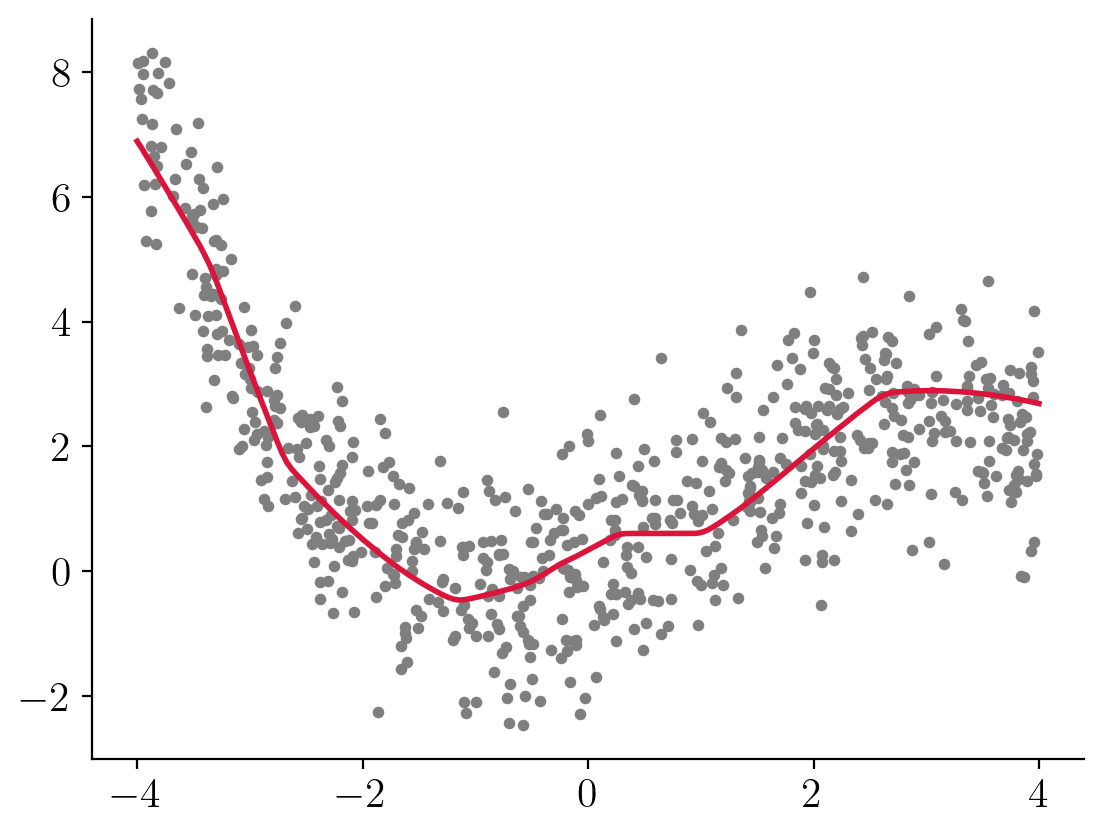

In [342]:
plt.plot(xeval, h_vmap(ensemble_final, xeval[:, None]).squeeze().mean(axis=-1), c="crimson")
plt.scatter(X, y, c="tab:gray", s=10)

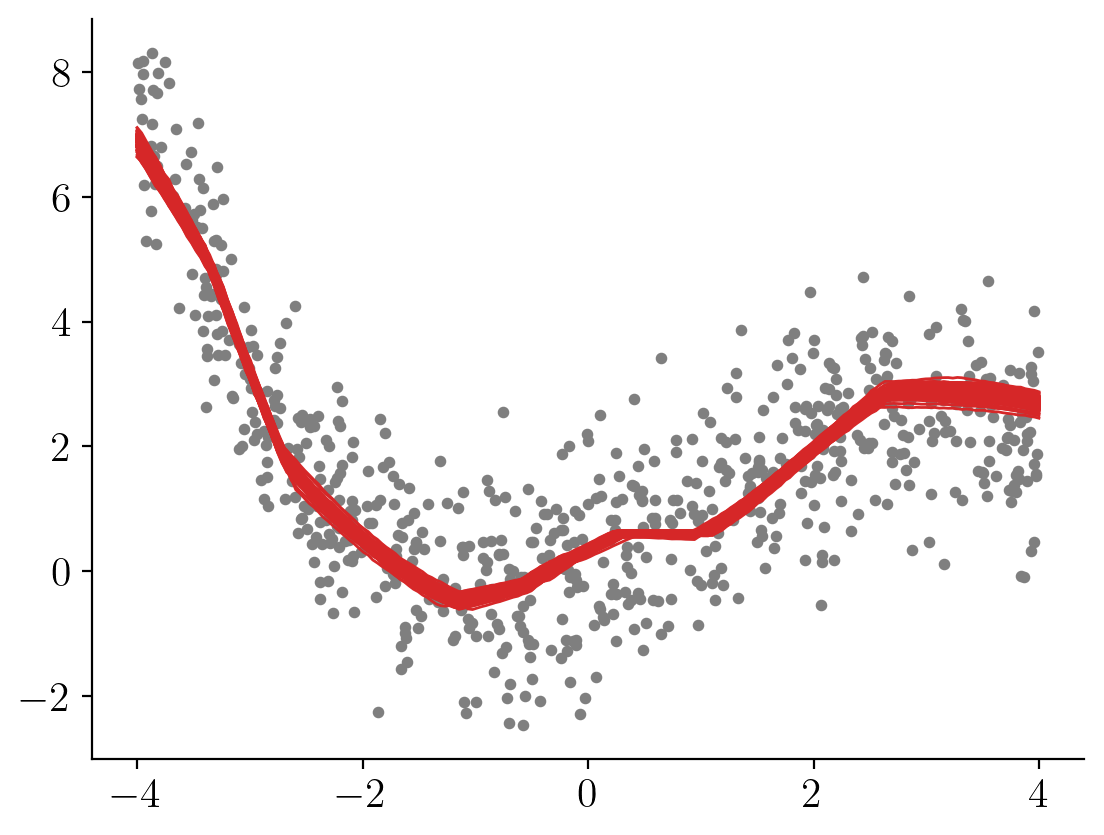

In [343]:
plt.plot(xeval, h_vmap(ensemble_final, xeval[:, None]).squeeze(), c="tab:red", linewidth=1)
plt.scatter(X, y, c="tab:gray", s=10)

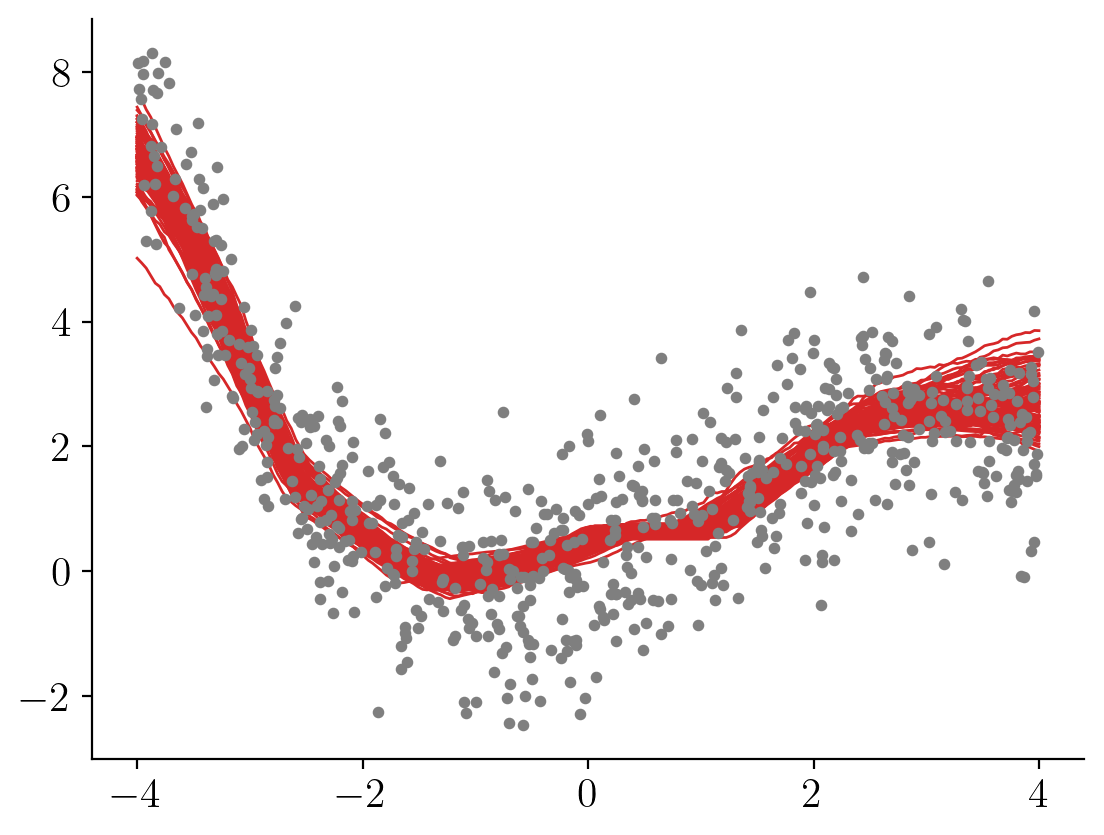

In [344]:
plt.scatter(X, y, c="tab:gray", s=10, zorder=3)
plt.plot(xeval, h_vmap(ensemble_hist[500], xeval[:, None]).squeeze(), c="tab:red", linewidth=1);
ymin, ymax = plt.ylim()

In [345]:
from matplotlib.animation import FuncAnimation

In [346]:
X_cpu = np.array(X)
y_cpu = np.array(y)
ensemble_hist_cpu = np.array(ensemble_hist)
xeval_cpu = np.array(xeval)

In [ ]:
fig, ax = plt.subplots()

def animate(t):
    print(f"@{t}", end="\r")
    ax.cla()
    ax.scatter(X_cpu[:t], y_cpu[:t], c="black", s=10, zorder=3)
    heval = np.array(h_vmap(ensemble_hist_cpu[t], xeval_cpu[:, None]).squeeze())
    ax.plot(xeval_cpu, heval, c="crimson", linewidth=1, alpha=0.7)
    plt.ylim(ymin, ymax)

anim = FuncAnimation(fig, animate, np.arange(0, 500, 2))
anim.save("../figures/enkf-nnet.gif", fps=20)